In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding

from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from keras.preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
from keras.callbacks import ReduceLROnPlateau
import tensorflow as tf

Importing the dataset

In [ ]:
true = pd.read_csv("/content/drive/MyDrive/True.csv")
false = pd.read_csv("/content/drive/MyDrive/Fake.csv")

In [ ]:
true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [ ]:
false.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [ ]:
true['category'] = 1
false['category'] = 0

In [ ]:
df = pd.concat([true,false]) #Merging the datasets

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


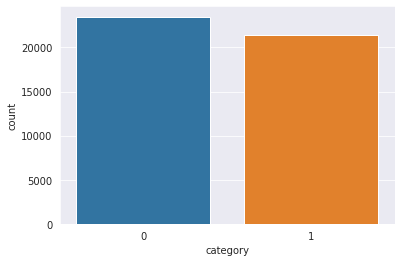

In [ ]:
sns.set_style("darkgrid")
sns.countplot(df.category)

In [ ]:
df.head()

,title,text,subject,date,category
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [ ]:
df.isna().sum() #Check for nan values

title       0
text        0
subject     0
date        0
category    0
dtype: int64

In [ ]:
df.title.count()

44898

In [ ]:
df.subject.value_counts()

politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: subject, dtype: int64

Merging all the text data into 1 column

[Text(0, 0, 'politicsNews'),
 Text(0, 0, 'worldnews'),
 Text(0, 0, 'News'),
 Text(0, 0, 'politics'),
 Text(0, 0, 'Government News'),
 Text(0, 0, 'left-news'),
 Text(0, 0, 'US_News'),
 Text(0, 0, 'Middle-east')]

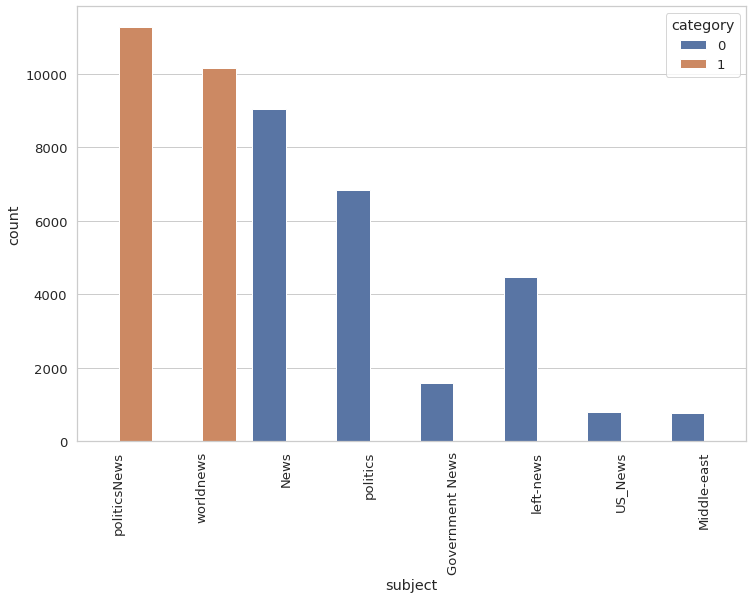

In [ ]:
plt.figure(figsize = (12,8))
sns.set(style = "whitegrid",font_scale = 1.2)
chart = sns.countplot(x = "subject", hue = "category" , data = df)
chart.set_xticklabels(chart.get_xticklabels(),rotation=90)

since the topics in the subject column are different for both categories, so we have to exclude it from the final text column

In [ ]:
df['text'] = df['text'] + " " + df['title']
del df['title']
del df['subject']
del df['date']

In [ ]:
import nltk
nltk.download('stopwords')
stop = set(stopwords.words('english')) #stopwords are words that does not add much meaning to a sentence
punctuation = list(string.punctuation)
stop.update(punctuation)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


DATA CLEANING

In [ ]:
from gensim.models.word2vec import Text8Corpus
from gensim.parsing.preprocessing import preprocess_string, strip_tags, strip_punctuation, strip_multiple_whitespaces, strip_numeric, remove_stopwords, strip_short # Preprocesssing
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)
#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    text= strip_multiple_whitespaces(text)
    text = strip_punctuation(text)
    return text

#Apply function on review column
df['text']=df['text'].apply(denoise_text)

In [ ]:
df.head()

,text,category
0,WASHINGTON Reuters head conservative Republi...,1
1,WASHINGTON Reuters Transgender people allowe...,1
2,WASHINGTON Reuters special counsel investiga...,1
3,WASHINGTON Reuters Trump campaign adviser Ge...,1
4,SEATTLE WASHINGTON Reuters President Donald ...,1


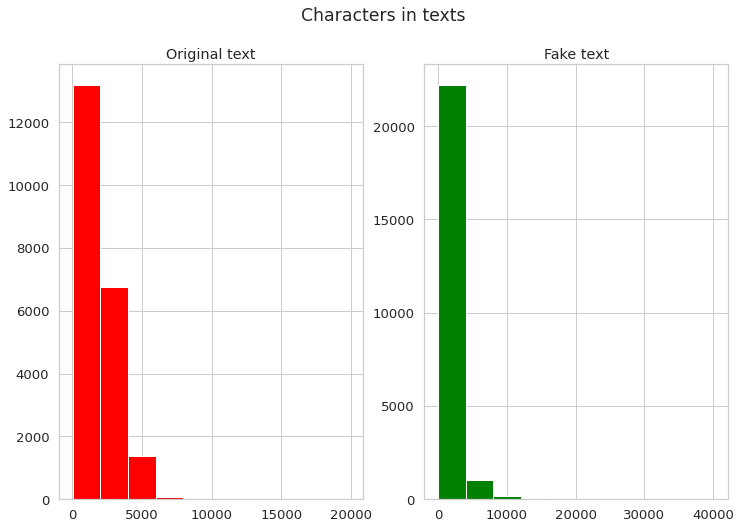

In [ ]:
# Number of characters in texts
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
text_len=df[df['category']==1]['text'].str.len()
ax1.hist(text_len,color='red')
ax1.set_title('Original text')
text_len=df[df['category']==0]['text'].str.len()
ax2.hist(text_len,color='green')
ax2.set_title('Fake text')
fig.suptitle('Characters in texts')
plt.show()

The distribution of both seems to be a bit different. 2500 characters in text is the most common in original text category while around 5000 characters in text are most common in fake text category.

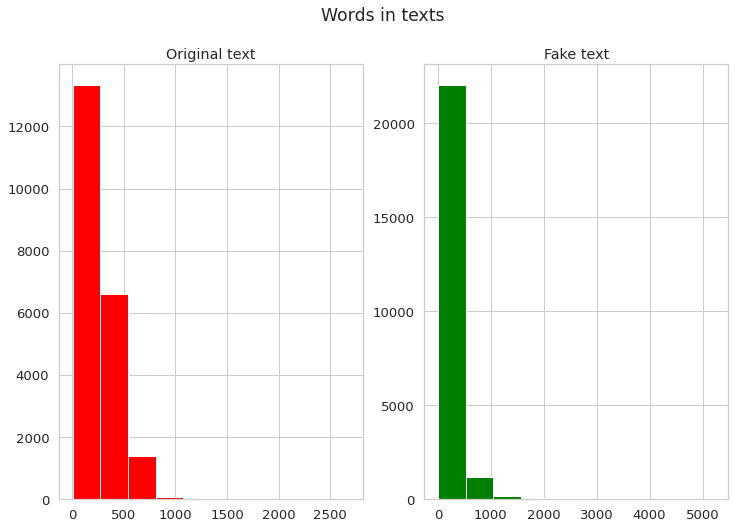

In [ ]:
# Number of words in each text
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
text_len=df[df['category']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(text_len,color='red')
ax1.set_title('Original text')
text_len=df[df['category']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(text_len,color='green')
ax2.set_title('Fake text')
fig.suptitle('Words in texts')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0.98, 'Average word length in each text')

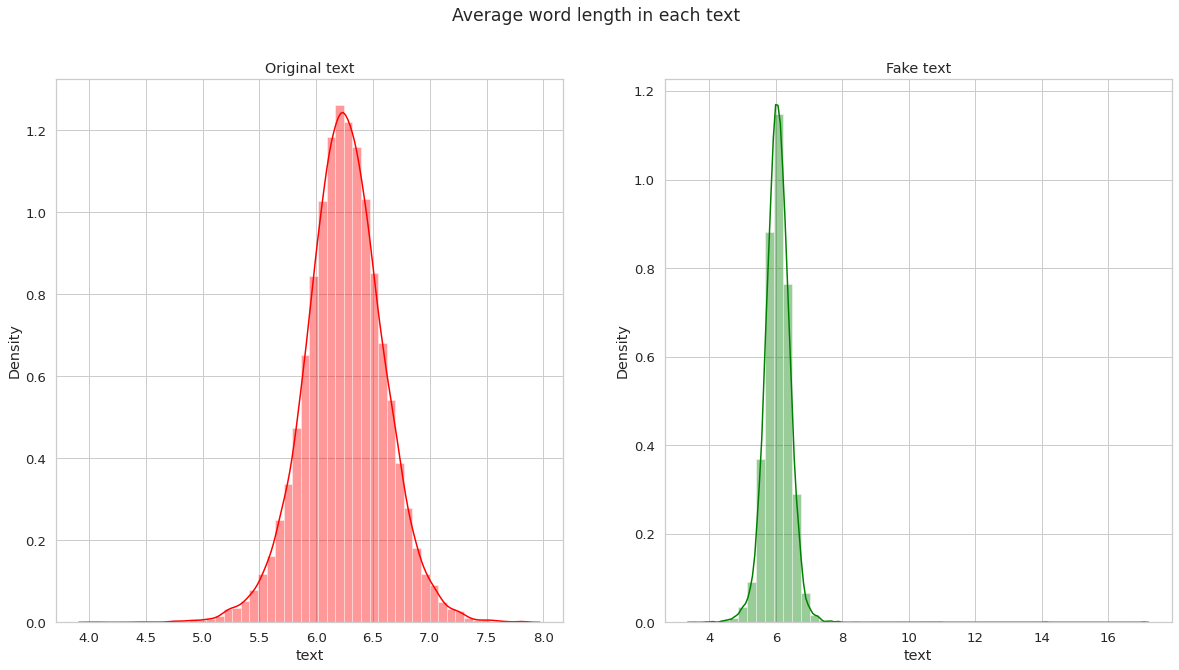

In [ ]:
# Average word lenght in a text
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
word=df[df['category']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('Original text')
word=df[df['category']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Fake text')
fig.suptitle('Average word length in each text')

In [ ]:
def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words
corpus = get_corpus(df.text)
corpus[:5]

['WASHINGTON', 'Reuters', 'head', 'conservative', 'Republican']

In [ ]:
from collections import Counter
counter = Counter(corpus)
most_common = counter.most_common(10)
most_common = dict(most_common)
most_common

{'President': 36871,
 'S': 55380,
 'Trump': 133179,
 'U': 59318,
 'also': 30526,
 'one': 32490,
 'people': 39619,
 'said': 132693,
 'would': 55048,
 '”': 41057}

In [ ]:
# Sorting words
from sklearn.feature_extraction.text import CountVectorizer
def get_top_text_ngrams(corpus, n, g):
    vec = CountVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

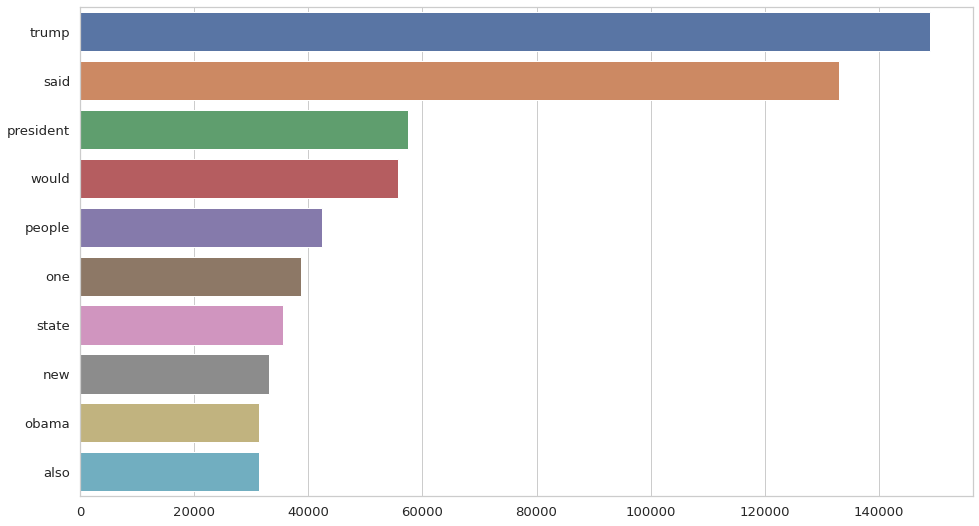

In [ ]:
#Unigram
plt.figure(figsize = (16,9))
most_common_uni = get_top_text_ngrams(df.text,10,1)
most_common_uni = dict(most_common_uni)
sns.barplot(x=list(most_common_uni.values()),y=list(most_common_uni.keys()))

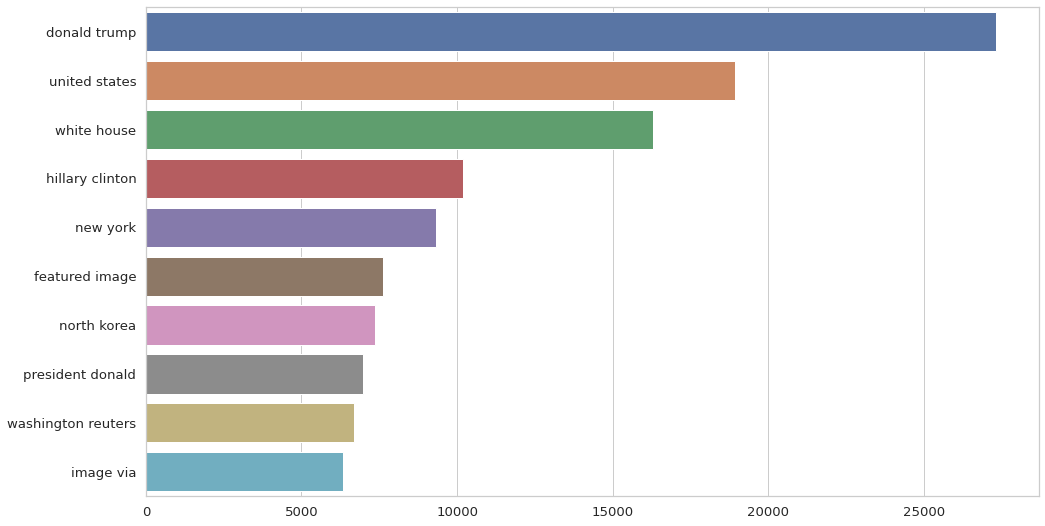

In [ ]:
# Biagram
plt.figure(figsize = (16,9))
most_common_bi = get_top_text_ngrams(df.text,10,2)
most_common_bi = dict(most_common_bi)
sns.barplot(x=list(most_common_bi.values()),y=list(most_common_bi.keys()))

In [ ]:
# Spliting data into training and testing data
x_train,x_test,y_train,y_test = train_test_split(df.text,df.category,random_state = 0)
max_features = 10000
maxlen = 300

In [ ]:
# Tokenizing Text -> Repsesenting each word by a number
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(x_train)
tokenized_train = tokenizer.texts_to_sequences(x_train)
x_train = sequence.pad_sequences(tokenized_train, maxlen=maxlen)

In [ ]:
tokenized_test = tokenizer.texts_to_sequences(x_test)
X_test = sequence.pad_sequences(tokenized_test, maxlen=maxlen)

In [ ]:
# Fitting Naive Bayes to the Training set
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(x_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

# Calculating accuracy
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

print(cm)

0.5643652561247215
[[3505 2353]
 [2537 2830]]


In [ ]:
# Fitting Logistic Regression to the Training set
from sklearn.linear_model import LogisticRegression
classifier1 = LogisticRegression(random_state = 0)
classifier1.fit(x_train, y_train)

# Predicting the Test set results
y_predL = classifier1.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm1 = confusion_matrix(y_test, y_predL)

# Calculating accuracy
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_predL))

print(cm1)

0.6344766146993318
[[4082 1776]
 [2327 3040]]


In [ ]:
# Fitting Decision Tree Classifier to the Training set
from sklearn.tree import DecisionTreeClassifier
classifier2 = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
classifier2.fit(x_train, y_train)

# Predicting the Test set results
y_predD = classifier2.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm2 = confusion_matrix(y_test, y_predD)

# Calculating accuracy
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_predD))

print(cm2)

0.819064587973274
[[5021  837]
 [1194 4173]]


In [ ]:
# Fitting Random Forest Classifier to the Training set
from sklearn.ensemble import RandomForestClassifier
classifier3 = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
classifier3.fit(x_train, y_train)

# Predicting the Test set results
y_predR = classifier3.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm3 = confusion_matrix(y_test, y_predR)

# Calculating accuracy
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_predR))


print(cm3)

0.7983964365256124
[[5184  674]
 [1589 3778]]


In [ ]:
# Fitting K Neighboors Classifier to the Training set
from sklearn.neighbors import KNeighborsClassifier
classifier4 = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
classifier4.fit(x_train, y_train)

# Predicting the Test set results
y_predK = classifier4.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm4 = confusion_matrix(y_test, y_predK)

# Calculating accuracy
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_predK))

print(cm4)

0.5914476614699332
[[3056 2802]
 [1784 3583]]


XGBoost

In [ ]:
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)
from xgboost import XGBClassifier
xgb = XGBClassifier(n_estimators = 1000, learning_rate = 0.15, max_depth = 9,
                    eval_metric = 'auc', use_label_encoder=False,objective = 'binary:logistic')
xgb.fit(x_train, y_train)

XGBClassifier(eval_metric='auc', learning_rate=0.15, max_depth=9,
              n_estimators=1000, use_label_encoder=False)

In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score

xgb_pred = xgb.predict( X_test)
xgb_score = accuracy_score(y_test, xgb_pred)
xgb_roc = roc_auc_score(y_test, xgb_pred)
print("The accuracy of XGBOOST is: %0.2f" %xgb_score)
print("The roc_auc score of XGBOOST is: %0.2f" %xgb_roc)

The accuracy of XGBOOST is: 0.96
The roc_auc score of XGBOOST is: 0.96


In [ ]:
from sklearn.metrics import classification_report
cr = classification_report(y_test, xgb_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.97      0.95      0.96      5858
           1       0.95      0.96      0.96      5367

    accuracy                           0.96     11225
   macro avg       0.96      0.96      0.96     11225
weighted avg       0.96      0.96      0.96     11225



In [ ]:
# Building the RNN
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_features, output_dim=100, input_length=maxlen, trainable=False),
    tf.keras.layers.LSTM(128,  return_sequences=True,recurrent_dropout=0.25, dropout=0.25),
    tf.keras.layers.LSTM(64,recurrent_dropout=0.1, dropout=0.1),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='mae', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 100)          1000000   
                                                                 
 lstm (LSTM)                 (None, 300, 128)          117248    
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,168,769
Trainable params: 168,769
Non-tr

In [ ]:
model.evaluate(X_test, y_test)

351/351 [==============================] - 55s 154ms/step - loss: 0.4999 - accuracy: 0.5115


[0.4999421536922455, 0.5115367770195007]

In [ ]:
pred = model.predict(X_test)

binary_predictions = []

for i in pred:
    if i >= 0.5:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0)

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
print('Accuracy on testing set:', accuracy_score(binary_predictions, y_test))
print('Precision on testing set:', precision_score(binary_predictions, y_test))
print('Recall on testing set:', recall_score(binary_predictions, y_test))

Accuracy on testing set: 0.5115367483296214
Precision on testing set: 0.07508850381963854
Recall on testing set: 0.4370932754880694


[Text(0, 0.5, '0'), Text(0, 1.5, '1')]

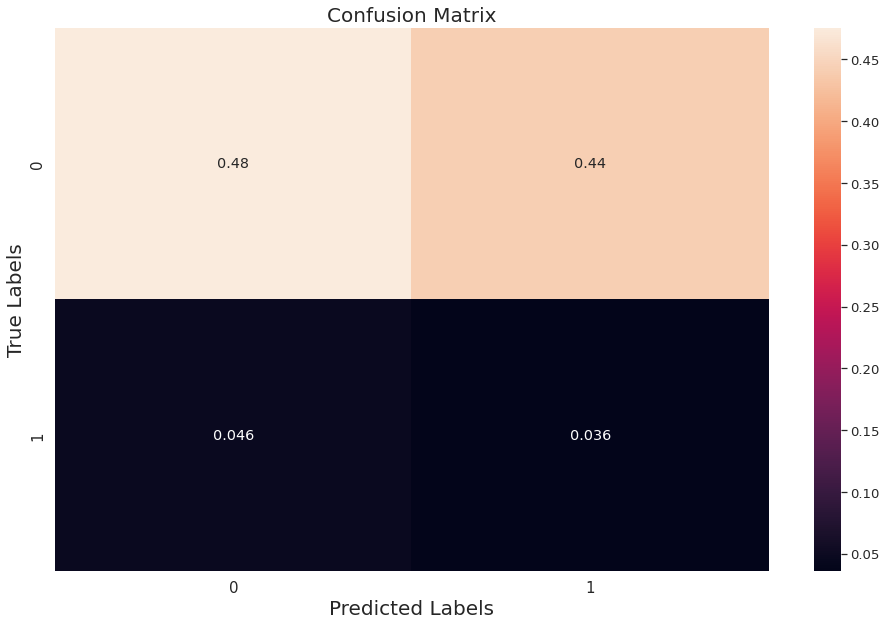

In [ ]:
matrix = confusion_matrix(binary_predictions, y_test, normalize='all')
plt.figure(figsize=(16, 10))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=20)
ax.set_ylabel('True Labels', size=20)
ax.set_title('Confusion Matrix', size=20)
ax.xaxis.set_ticklabels([0,1], size=15)
ax.yaxis.set_ticklabels([0,1], size=15)